## COGS 181 Final Project

Anni Li <br>
Ruoxuan Li

### Description

### Environment Preparation

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.optim as optim
import copy
from sklearn.model_selection import train_test_split
import cv2

In [2]:
# unzip the dataset
!tar -xvzf CUB_200_2011.tgz -q

In [2]:
# set up the device
if torch.cuda.is_available():
    device = torch.device("cuda")          
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('Using CPU')

Using GPU: NVIDIA GeForce RTX 3070 Laptop GPU


In [3]:
# avoid CUDA errors
CUDA_LAUNCH_BLOCKING=1

### Data Processing

#### Combine the necessary .txt files in the dataset package into one data frame

In [4]:
labels = pd.read_csv("CUB_200_2011/image_class_labels.txt", header=None, sep = " ")
labels.columns = ["id", "label"]

In [5]:
species = pd.read_csv("CUB_200_2011/classes.txt", header=None, sep = " ")
species.columns = ["label", "species"]

In [6]:
train_test = pd.read_csv("CUB_200_2011/train_test_split.txt", header=None, sep=" ")
train_test.columns = ["id", "is_train"]

In [7]:
image_names = pd.read_csv("CUB_200_2011/images.txt", header=None, sep=" ")
image_names.columns = ["id", "image_name"]

In [8]:
classes = pd.read_csv("CUB_200_2011/classes.txt", header=None, sep = " ")
classes.columns = ["label", "species"]
classes["label"] = classes["label"] - 1
classes

,label,species
0,0,001.Black_footed_Albatross
1,1,002.Laysan_Albatross
2,2,003.Sooty_Albatross
3,3,004.Groove_billed_Ani
4,4,005.Crested_Auklet
...,...,...
195,195,196.House_Wren
196,196,197.Marsh_Wren
197,197,198.Rock_Wren
198,198,199.Winter_Wren


In [9]:
data = pd.merge(image_names, train_test, on="id")
data = pd.merge(data, labels, on="id")
data = pd.merge(data, species, on="label")
data["label"] = data["label"] - 1
data

,id,image_name,is_train,label,species
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,0,0,001.Black_footed_Albatross
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0,001.Black_footed_Albatross
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,0,0,001.Black_footed_Albatross
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0,001.Black_footed_Albatross
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0,001.Black_footed_Albatross
...,...,...,...,...,...
11783,11784,200.Common_Yellowthroat/Common_Yellowthroat_00...,1,199,200.Common_Yellowthroat
11784,11785,200.Common_Yellowthroat/Common_Yellowthroat_00...,0,199,200.Common_Yellowthroat
11785,11786,200.Common_Yellowthroat/Common_Yellowthroat_00...,0,199,200.Common_Yellowthroat
11786,11787,200.Common_Yellowthroat/Common_Yellowthroat_00...,1,199,200.Common_Yellowthroat


#### Define the dataset class and necessary data processing functions

In [10]:
class CUBdata(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = Image.open( "CUB_200_2011/images/" + self.data.loc[index, "image_name"]).convert("RGB")
        label = self.data.loc[index, "label"]
        if self.transform is not None:
            image = self.transform(image)
            image = normalize_image(image)
        return image, label

In [10]:
transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor()
])

In [11]:
def normalize_image(tensorimage):
    image_min = tensorimage.min()
    image_max = tensorimage.max()
    tensorimage.clamp_(min=image_min, max=image_max)
    tensorimage.add_(-image_min).div_(image_max - image_min + 1e-5)
    return tensorimage

#### Plot some images with labels to have a look

In [12]:
def plot_images(images, labels, normalize=True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig, axs = plt.subplots(rows, cols, figsize = (15,15))
    axs = axs.ravel() 
    for i in range(rows*cols):
        image = Image.open("CUB_200_2011/images/" + images[i]).convert('RGB')
        image = transform(image)
        if normalize:
            image = normalize_image(image)
        image = image.numpy()
        
        axs[i].imshow(np.transpose(image, (1, 2, 0)))
        label = labels[i]
        axs[i].set_title(label)
        axs[i].set_axis_off()

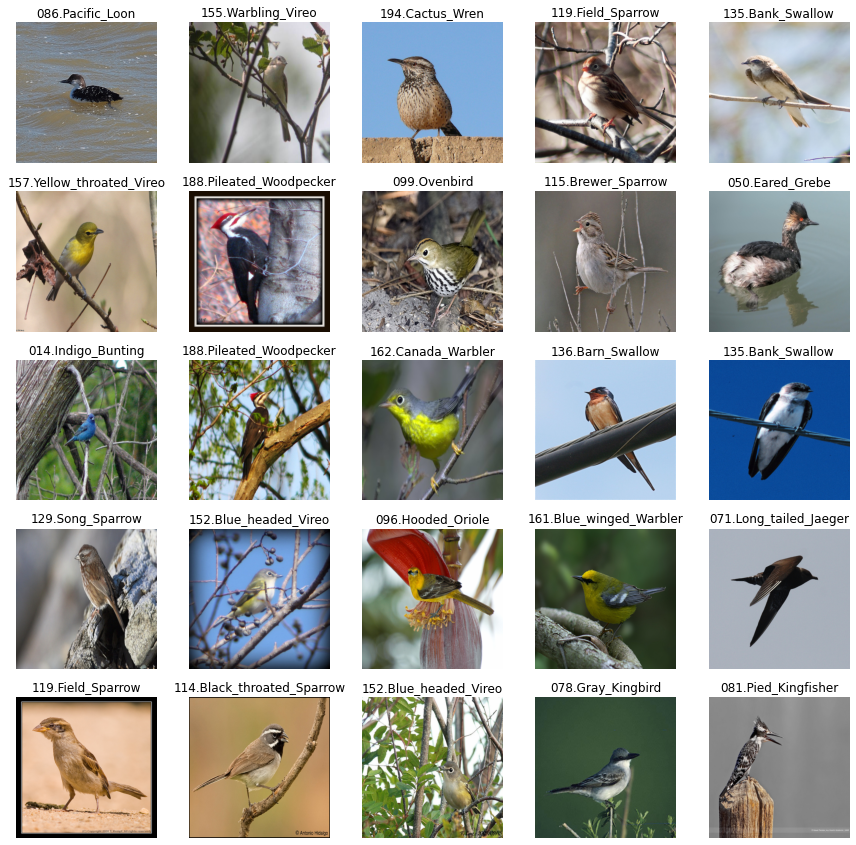

In [14]:
imagelist = []
labellist = []
randomlist = [random.randint(0, len(data)) for _ in range(25)]
for i in randomlist:
    imagelist.append(data.loc[i, 'image_name'])
    labellist.append(data.loc[i, 'species'])
plot_images(imagelist, labellist)

#### Define the data loader and CNN model

In [30]:
train_data = data[data["is_train"] == 1]
train_data = train_data.reset_index(drop=True)

train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
train_data = train_data.reset_index(drop=True)
trainset = CUBdata(train_data, transform=transform)
trainloader = DataLoader(trainset, batch_size=8, shuffle=True)

val_data = val_data.reset_index(drop=True)
valset = CUBdata(val_data, transform=transform)
valloader = DataLoader(valset, batch_size=8, shuffle=False)
                       
test_data = data[data["is_train"] == 0]
test_data = test_data.reset_index(drop=True)
testset = CUBdata(test_data, transform=transform)
testloader = DataLoader(testset, batch_size=8, shuffle=False)

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(32 * 112 * 112, 200)
        
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return x

In [32]:
net = Net()
net.to(device)
loss_func = nn.CrossEntropyLoss().to(device)
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

### Training

In [33]:
avg_losses = []
num_epoch = 100
print_freq = 5

for epoch in range(num_epoch):
    running_loss = 0.0
    for i, trainstat in enumerate(trainloader, 0):
        inputs, ytrue = trainstat
        inputs, ytrue = inputs.to(device), ytrue.to(device)
        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_func(outputs, ytrue)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    avg_loss = running_loss / len(trainloader)
    avg_losses.append(avg_loss)
    
    if epoch % print_freq == (print_freq - 1):
        print('[epoch %d] loss: %.3f' % (epoch + 1, avg_loss))
        
print('Finished Training')

[epoch 5] loss: 4.243
[epoch 10] loss: 2.707
[epoch 15] loss: 2.690
[epoch 20] loss: 2.688
[epoch 25] loss: 2.689
[epoch 30] loss: 2.688
[epoch 35] loss: 2.687
[epoch 40] loss: 2.687
[epoch 45] loss: 2.689
[epoch 50] loss: 2.687
[epoch 55] loss: 2.691
[epoch 60] loss: 2.689
[epoch 65] loss: 2.689
[epoch 70] loss: 2.689
[epoch 75] loss: 2.691
[epoch 80] loss: 2.689
[epoch 85] loss: 2.687
[epoch 90] loss: 2.689
[epoch 95] loss: 2.689
[epoch 100] loss: 2.687
Finished Training


### Evaluate

In [34]:
correct = 0
total = 0
# for storing the predictions and true labels
predicted_labels = []
true_labels = []
with torch.no_grad():
    for teststat in testloader:
        inputs, ytrue = teststat
        inputs, ytrue = inputs.to(device), ytrue.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += ytrue.size(0)
        correct += (predicted == ytrue).sum().item()
        # store predicted_labels and true_labels
        predicted_labels.extend(predicted.cpu().numpy().tolist())
        true_labels.extend(ytrue.cpu().numpy().tolist())

print('Accuracy of the network on the %d test images: %d %%' % 
      (len(testset), 100 * correct / total))

Accuracy of the network on the 5794 test images: 4 %


### Randomly test a image prediction

In [35]:
def display_prediction(image, species, probability):
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Predicted species: {species}\nProbability: {probability:.2f}')
    plt.show()

The random index is 2366
The correct label is 042.Vermilion_Flycatcher


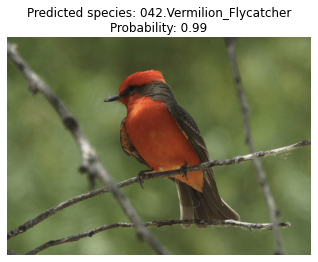

In [56]:
example_idx = random.randint(0, len(data))
example_label = data[data["id"]==example_idx]["species"].values[0]
example = Image.open("CUB_200_2011/images/" + data.loc[example_idx, "image_name"])
example_tensor = transform(example).unsqueeze(0).to(device)

with torch.no_grad():
    output = net(example_tensor)
    probabilities = F.softmax(output, dim=1)
    
pred_label = torch.argmax(probabilities).item()
pred_species = classes.loc[classes["label"]==pred_label]["species"].values[0]

print(f"The random index is {example_idx}")
print(f"The correct label is {example_label}")
display_prediction(example, pred_species, probabilities[0][pred_label].item())

### Metrics

In [57]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
def report_metrics(true_labels, predicted_labels):
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print("Precision: %.3f" % precision)
    print("Recall: %.3f " % recall)
    print("Confusion matrix:")
    print(conf_matrix)  

In [58]:
report_metrics(true_labels, predicted_labels)

Precision: 0.046
Recall: 0.049 
Confusion matrix:
[[11  0  0 ...  1  0  0]
 [15  0  1 ...  0  0  0]
 [13  0  2 ...  0  0  0]
 ...
 [ 9  0  0 ...  4  0  0]
 [18  0  0 ...  0  0  0]
 [12  0  0 ...  0  0  0]]


C:\Users\84592\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Loss Curve

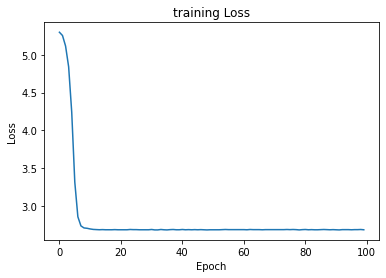

In [59]:
import matplotlib.pyplot as plt
plt.plot(avg_losses)
plt.title("training Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Add Mask

In [13]:
parts = pd.read_csv("CUB_200_2011/parts/part_locs.txt", sep=" ", header=None, names=["id", "part_id", "x", "y", "displayed"])

In [14]:
parts_locs = parts[parts["displayed"] == 1]
parts_locs = parts_locs.reset_index(drop=True)
parts_locs

,id,part_id,x,y,displayed
0,1,2,312.0,182.0,1
1,1,5,186.0,45.0,1
2,1,6,247.0,79.0,1
3,1,10,100.0,221.0,1
4,1,11,183.0,101.0,1
...,...,...,...,...,...
141402,11788,11,136.0,133.0,1
141403,11788,12,102.0,316.0,1
141404,11788,13,94.0,224.0,1
141405,11788,14,36.0,329.0,1


In [15]:
def create_mask(image, part_points, dilation_size=80, drop=True):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    hull = cv2.convexHull(np.array(part_points, dtype=np.int32))
    
    if drop is True:
        h, w = image.shape[:2]
        distances = [min(x, y, w - x, h - y) for x, y in hull[:, 0]]
        drop_point_index = distances.index(min(distances))
        hull = np.delete(hull, drop_point_index, axis=0)

    cv2.drawContours(mask, [hull], 0, 255, -1)
    kernel = np.ones((dilation_size, dilation_size), np.uint8)
    dilated_mask = cv2.dilate(mask, kernel, iterations=1)
    
    return dilated_mask

In [16]:
def extract_bird(image, mask):
    extracted_bird = cv2.bitwise_and(image, image, mask=mask)
    return extracted_bird

In [17]:
def plot_masked_images(ids, images, labels, normalize=True, drop=True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig, axs = plt.subplots(rows, cols, figsize = (15,15))
    axs = axs.ravel() 
    
    for i in range(rows*cols):
        parts_img = parts_locs[parts_locs["id"] == ids[i]][["x", "y"]].values
        cvimage = cv2.imread("CUB_200_2011/images/" + images[i])
        cvimage = cv2.cvtColor(cvimage, cv2.COLOR_BGR2RGB)
        mask = create_mask(cvimage, parts_img, drop=drop)
        extracted_bird = extract_bird(cvimage, mask)
        image = Image.fromarray(extracted_bird)
        image = transform(image)
        if normalize:
            image = normalize_image(image)
        image = image.numpy()
        
        axs[i].imshow(np.transpose(image, (1, 2, 0)))
        label = labels[i]
        axs[i].set_title(label)
        axs[i].set_axis_off()

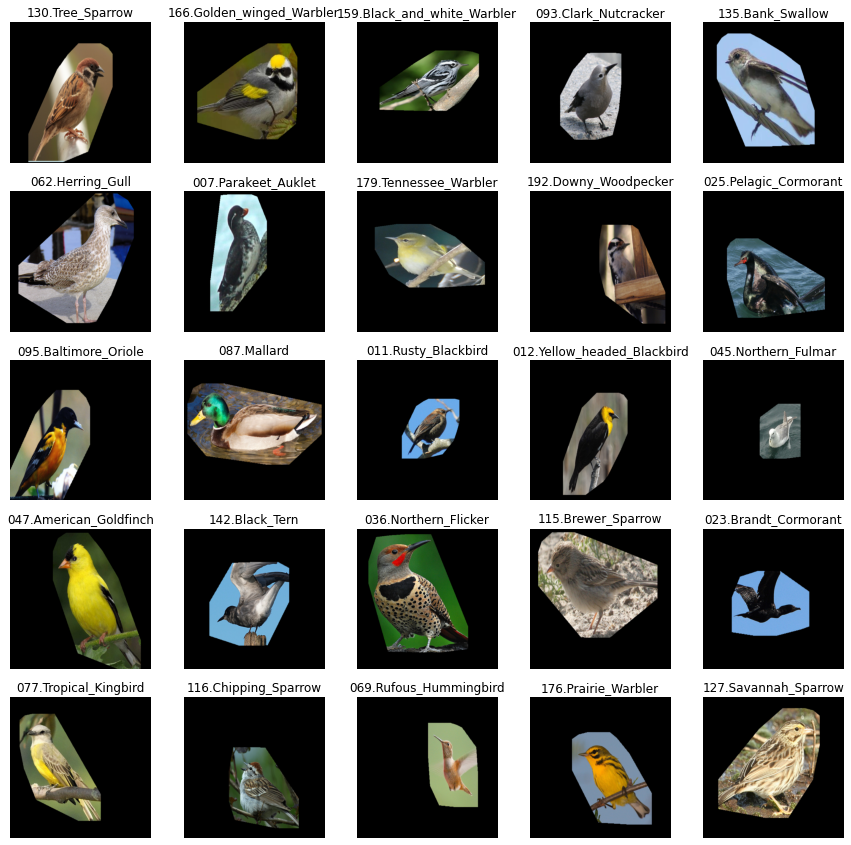

In [18]:
ids = []
imagelist = []
labellist = []
randomlist = [random.randint(0, len(data)) for _ in range(25)]
for i in randomlist:
    ids.append(data.loc[i, 'id'])
    imagelist.append(data.loc[i, 'image_name'])
    labellist.append(data.loc[i, 'species'])
plot_masked_images(ids, imagelist, labellist, drop=False)

In [19]:
class CUBdata2(Dataset):
    def __init__(self, data, parts_locs, transform=None):
        self.data = data
        self.parts_locs = parts_locs
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = "CUB_200_2011/images/" + self.data.loc[index, "image_name"]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image_id = self.data.loc[index, "id"]
        part_points = self.parts_locs[self.parts_locs["id"] == image_id][["x", "y"]].values
        
        mask = create_mask(image, part_points, dilation_size=80, drop=True)
        extracted_bird = extract_bird(image, mask)
        
        image = Image.fromarray(extracted_bird)
        
        label = self.data.loc[index, "label"]
        if self.transform is not None:
            image = self.transform(image)
            image = normalize_image(image)
        return image, label

In [20]:
train_data = data[data["is_train"] == 1]
train_data = train_data.reset_index(drop=True)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

train_data = train_data.reset_index(drop=True)
trainset = CUBdata2(train_data, parts_locs, transform=transform)
trainloader = DataLoader(trainset, batch_size=8, shuffle=True)

val_data = val_data.reset_index(drop=True)
valset = CUBdata2(val_data, parts_locs, transform=transform)
valloader = DataLoader(valset, batch_size=8, shuffle=False)

test_data = data[data["is_train"] == 0]
test_data = test_data.reset_index(drop=True)
testset = CUBdata2(test_data, parts_locs, transform=transform)
testloader = DataLoader(testset, batch_size=8, shuffle=False)

In [26]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, 200)
        
        self.flatten = nn.Flatten()
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(self.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(self.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(self.leaky_relu(self.bn3(self.conv3(x))))
        
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Training

In [27]:
net2 = Net2().to(device)
loss_func = nn.CrossEntropyLoss().to(device)
opt = torch.optim.Adam(net2.parameters(), lr=0.001, weight_decay=1e-4)

In [28]:
train_avg_losses = []
val_avg_losses = []
num_epoch = 100
patience = 10 
best_val_loss = float('inf')
best_model = None
counter = 0

for epoch in range(num_epoch):
    net2.train()
    train_running_loss = 0.0
    train_num_iterations = 0

    for i, trainstat in enumerate(trainloader, 0):
        inputs, ytrue = trainstat
        inputs, ytrue = inputs.to(device), ytrue.to(device)
        opt.zero_grad()

        outputs = net2(inputs)
        loss = loss_func(outputs, ytrue)
        loss.backward()
        opt.step()

        train_running_loss  += loss.item()
        train_num_iterations += 1
        
    train_avg_loss = train_running_loss / train_num_iterations
    train_avg_losses.append(train_avg_loss)
    
    net2.eval()
    val_running_loss  = 0.0
    val_num_iterations  = 0
    
    with torch.no_grad():
        for i, valstat in enumerate(valloader, 0):
            inputs, ytrue = valstat
            inputs, ytrue = inputs.to(device), ytrue.to(device)

            outputs = net2(inputs)
            loss = loss_func(outputs, ytrue)

            val_running_loss += loss.item()
            val_num_iterations += 1

    val_avg_loss = val_running_loss / val_num_iterations
    val_avg_losses.append(val_avg_loss)
        
    print(f'Epoch: {epoch + 1}, Training Loss: {train_avg_loss:.3f}, Validation Loss: {val_avg_loss:.3f}')
    
    if val_avg_loss < best_val_loss:
        best_val_loss = val_avg_loss
        best_model = copy.deepcopy(net2)
        counter = 0
    else:
        counter += 1
        print(f'EarlyStopping counter: {counter} out of {patience}')
        if counter >= patience:
            print("Early stopping triggered. Stopping training.")
            break
                
print('Finished Training')
net2 = best_model
    

Epoch: 1, Training Loss: 9.366, Validation Loss: 5.346
Epoch: 2, Training Loss: 4.861, Validation Loss: 5.215
Epoch: 3, Training Loss: 3.025, Validation Loss: 5.418
EarlyStopping counter: 1 out of 10
Epoch: 4, Training Loss: 1.312, Validation Loss: 6.676
EarlyStopping counter: 2 out of 10
Epoch: 5, Training Loss: 0.825, Validation Loss: 6.822
EarlyStopping counter: 3 out of 10
Epoch: 6, Training Loss: 0.589, Validation Loss: 6.499
EarlyStopping counter: 4 out of 10
Epoch: 7, Training Loss: 0.576, Validation Loss: 8.014
EarlyStopping counter: 5 out of 10
Epoch: 8, Training Loss: 0.538, Validation Loss: 8.405
EarlyStopping counter: 6 out of 10
Epoch: 9, Training Loss: 0.608, Validation Loss: 8.110
EarlyStopping counter: 7 out of 10
Epoch: 10, Training Loss: 0.504, Validation Loss: 7.837
EarlyStopping counter: 8 out of 10
Epoch: 11, Training Loss: 0.496, Validation Loss: 9.063
EarlyStopping counter: 9 out of 10
Epoch: 12, Training Loss: 0.490, Validation Loss: 10.000
EarlyStopping counter

### Evaluate

In [29]:
correct = 0
total = 0
# for storing the predictions and true labels
predicted_labels = []
true_labels = []
with torch.no_grad():
    for teststat in testloader:
        inputs, ytrue = teststat
        inputs, ytrue = inputs.to(device), ytrue.to(device)
        outputs = net2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += ytrue.size(0)
        correct += (predicted == ytrue).sum().item()
        # store predicted_labels and true_labels
        predicted_labels.extend(predicted.cpu().numpy().tolist())
        true_labels.extend(ytrue.cpu().numpy().tolist())

print('Accuracy of the network on the %d test images: %d %%' % 
      (len(testset), 100 * correct / total))

KeyboardInterrupt: 

### Randomly test a image prediction

In [101]:
def display_prediction(image, species, probability):
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Predicted species: {species}\nProbability: {probability:.2f}')
    plt.show()

The random index is 11170
The correct label is 190.Red_cockaded_Woodpecker


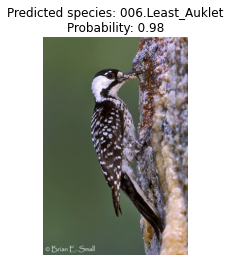

In [205]:
example_idx = random.randint(0, len(data))
example_label = data[data["id"]==example_idx]["species"].values[0]
example = Image.open("CUB_200_2011/images/" + data.loc[example_idx, "image_name"])
example_tensor = transform(example).unsqueeze(0).to(device)

with torch.no_grad():
    output = net2(example_tensor)
    probabilities = F.softmax(output, dim=1)
    
pred_label = torch.argmax(probabilities).item()
pred_species = classes.loc[classes["label"]==pred_label]["species"].values[0]

print(f"The random index is {example_idx}")
print(f"The correct label is {example_label}")
display_prediction(example, pred_species, probabilities[0][pred_label].item())

### Metrics

In [30]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
def report_metrics(true_labels, predicted_labels):
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print("Precision: %.3f" % precision)
    print("Recall: %.3f " % recall)
    print("Confusion matrix:")
    print(conf_matrix)  

In [31]:
report_metrics(true_labels, predicted_labels)

Precision: 0.001
Recall: 0.012 
Confusion matrix:
[[0 1 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 2 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


C:\Users\84592\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Loss Curve

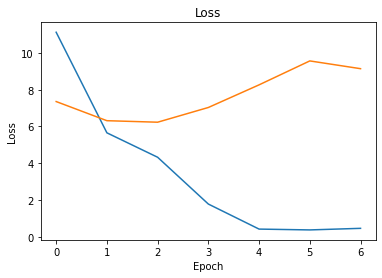

In [206]:
import matplotlib.pyplot as plt
plt.plot(train_avg_losses)
plt.plot(val_avg_losses)
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## BCNN

In [223]:
train_data = data[data["is_train"] == 1]
train_data = train_data.reset_index(drop=True)

train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
train_data = train_data.reset_index(drop=True)
trainset = CUBdata(train_data, transform=transform)
trainloader = DataLoader(trainset, batch_size=8, shuffle=True)

val_data = val_data.reset_index(drop=True)
valset = CUBdata(val_data, transform=transform)
valloader = DataLoader(valset, batch_size=8, shuffle=False)
                       
test_data = data[data["is_train"] == 0]
test_data = test_data.reset_index(drop=True)
testset = CUBdata(test_data, transform=transform)
testloader = DataLoader(testset, batch_size=8, shuffle=False)

In [224]:
class BCNN_fc(nn.Module):
    def __init__(self):
        super(BCNN_fc, self).__init__()
        self.features = torchvision.models.vgg16(pretrained=True).features
        self.features = nn.Sequential(*list(self.features.children())[:-1])
        self.fc = nn.Linear(512*512, 200)
        for param in self.features.parameters():
            param.requres_grad = False
        nn.init.kaiming_normal_(self.fc.weight.data)
        if self.fc.bias is not None:
            nn.init.constant_(self.fc.bias.data, val=0)
 
    def forward(self, x):
        N = x.size()[0]
        assert x.size() == (N, 3, 448, 448)
        x = self.features(x)
        assert x.size() == (N, 512, 28, 28)
        x = x.view(N, 512, 28*28)
        x = torch.bmm(x, torch.transpose(x, 1, 2)) / (28*28)
        assert x.size() == (N, 512, 512)
        x = x.view(N, 512*512)
        x = torch.sqrt(x + 1e-5)
        x = torch.nn.functional.normalize(x)
        x = self.fc(x)
        assert x.size() == (N, 200)
        return x


In [228]:
class BCNN_all(nn.Module):
    def __init__(self):
        super(BCNN_all, self).__init__()
        self.features = torchvision.models.vgg16(pretrained=False).features
        self.features = torch.nn.Sequential(*list(self.features.children())[:-1])
        self.fc = torch.nn.Linear(512*512, 200)
 
    def forward(self, x):
        N = x.size()[0]
        assert x.size() == (N, 3, 448, 448)
        x = self.features(x)
        assert x.size() == (N, 512, 28, 28)
        x = x.view(N, 512, 28*28)
        x = torch.bmm(x, torch.transpose(x, 1, 2))/(28*28)  # 双线性
        assert x.size() == (N, 512, 512)
        x = x.view(N, 512*512)
        x = torch.sqrt(x + 1e-5)
        x = torch.nn.functional.normalize(x)
        x = self.fc(x)
        assert x.size() == (N, 200)
        return x

In [229]:
net = BCNN_all().to(device)
loss_func = nn.CrossEntropyLoss().to(device)
opt = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)

C:\Users\84592\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\84592\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [230]:
train_avg_losses = []
val_avg_losses = []
num_epoch = 600
patience = 10 
best_val_loss = float('inf')
best_model = None
counter = 0

for epoch in range(num_epoch):
    net.train()
    train_running_loss = 0.0
    train_num_iterations = 0

    for i, trainstat in enumerate(trainloader, 0):
        inputs, ytrue = trainstat
        inputs, ytrue = inputs.to(device), ytrue.to(device)
        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_func(outputs, ytrue)
        loss.backward()
        opt.step()

        train_running_loss  += loss.item()
        train_num_iterations += 1
        
    train_avg_loss = train_running_loss / train_num_iterations
    train_avg_losses.append(train_avg_loss)
    
    net.eval()
    val_running_loss  = 0.0
    val_num_iterations  = 0
    
    with torch.no_grad():
        for i, valstat in enumerate(valloader, 0):
            inputs, ytrue = valstat
            inputs, ytrue = inputs.to(device), ytrue.to(device)

            outputs = net(inputs)
            loss = loss_func(outputs, ytrue)

            val_running_loss += loss.item()
            val_num_iterations += 1

    val_avg_loss = val_running_loss / val_num_iterations
    val_avg_losses.append(val_avg_loss)
        
    print(f'Epoch: {epoch + 1}, Training Loss: {train_avg_loss:.3f}, Validation Loss: {val_avg_loss:.3f}')
    
    if val_avg_loss < best_val_loss:
        best_val_loss = val_avg_loss
        best_model = copy.deepcopy(net)
        counter = 0
    else:
        counter += 1
        print(f'EarlyStopping counter: {counter} out of {patience}')
        if counter >= patience:
            print("Early stopping triggered. Stopping training.")
            break
                
print('Finished Training')
net = best_model

Epoch: 1, Training Loss: 5.417, Validation Loss: 5.354
Epoch: 2, Training Loss: 5.344, Validation Loss: 5.338
Epoch: 3, Training Loss: 5.326, Validation Loss: 5.344
EarlyStopping counter: 1 out of 10
Epoch: 4, Training Loss: 5.320, Validation Loss: 5.341
EarlyStopping counter: 2 out of 10
Epoch: 5, Training Loss: 5.316, Validation Loss: 5.340
EarlyStopping counter: 3 out of 10


KeyboardInterrupt: 

### Evaluate

In [231]:
correct = 0
total = 0
# for storing the predictions and true labels
predicted_labels = []
true_labels = []
with torch.no_grad():
    for teststat in testloader:
        inputs, ytrue = teststat
        inputs, ytrue = inputs.to(device), ytrue.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += ytrue.size(0)
        correct += (predicted == ytrue).sum().item()
        # store predicted_labels and true_labels
        predicted_labels.extend(predicted.cpu().numpy().tolist())
        true_labels.extend(ytrue.cpu().numpy().tolist())

print('Accuracy of the network on the %d test images: %d %%' % 
      (len(testset), 100 * correct / total))

Accuracy of the network on the 5794 test images: 0 %


### Randomly test a image prediction

The random index is 6714
The correct label is 115.Brewer_Sparrow


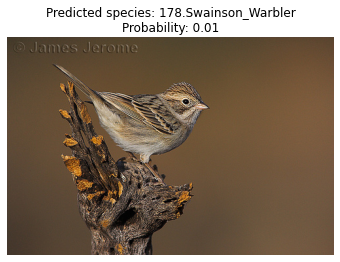

In [249]:
example_idx = random.randint(0, len(data))
example_label = data[data["id"]==example_idx]["species"].values[0]
example = Image.open("CUB_200_2011/images/" + data.loc[example_idx, "image_name"])
example_tensor = transform(example).unsqueeze(0).to(device)

with torch.no_grad():
    output = net(example_tensor)
    probabilities = F.softmax(output, dim=1)
    
pred_label = torch.argmax(probabilities).item()
pred_species = classes.loc[classes["label"]==pred_label]["species"].values[0]

print(f"The random index is {example_idx}")
print(f"The correct label is {example_label}")
display_prediction(example, pred_species, probabilities[0][pred_label].item())

### Metrics

In [234]:
report_metrics(true_labels, predicted_labels)

Precision: 0.000
Recall: 0.004 
Confusion matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


C:\Users\84592\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Loss Curve

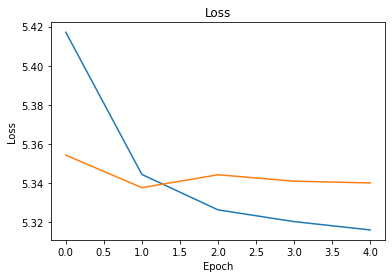

In [235]:
import matplotlib.pyplot as plt
plt.plot(train_avg_losses)
plt.plot(val_avg_losses)
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Possible improvements:
on data processing: 
- binding box w/ parts
- zero padding to erase background <br>

on model:
- combine with transformer
- mask-CNN
- parameters, batchsize, optimizers, etc